This an example of using the function corr_2d_ttest to calculate field correlations and their significance. The significant test applys for non IID (independent and identically distributed) time series, considering autocorrelations and multiple test problem.

The false discovery rate (FDR) method is applied to take care of the multiple test problem. The FDR code is from Dr. Chris Paciorek (https://www.stat.berkeley.edu/~paciorek/research/code/code.html).

Please import the corr_2d_ttest and corr_sig functions.

Required packages: numpy, scipy, rpy2, statsmodels, sklearn, collections, pandas

In [34]:
import numpy as np
import xarray as xr
from corr_2d_ttest import *
from corr_sig import *

from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

Here we take the surface air temperature as an example. We will calculate the monthly correlation between surface air temperature at Los Angeles and surface air temperature of the North America. The data is from NCEP/NCAR reanalysis.

In [35]:
# Open data from the NCEP OpenDAP server
url = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/surface/air.mon.mean.nc'
ds = xr.open_dataset(url)

In [36]:
# select surface air temperature from 1979
air = ds.air[372:,:,:]

In [37]:
# North America surface air temperature
# field1 (time,lat,lon)
air_NA = air.sel(lat=slice(60,0),lon=slice(200,340))

In [38]:
# Los Angeles surface air temperature
# field2 (time)
air_LA = air.sel(lat=34.05,lon=241.76,method='nearest')

In [39]:
#Get lat and lon of air_NA
# lat,lon should be consistent with the size of field1
lat = air_NA.lat
lon = air_NA.lon

Now we calculate field correlations and their significance. We can set parameters in "options" below. These parameters are:
-  method: There are three methods to choose: "ttest", "isopersistent" and "isospectral". 
   - 'ttest': T-test where d.o.f are corrected for the effect of serial correlation
   - 'isopersistent': a non-parametric (Monte Carlo) significance test by simulating of correlations with nsim AR(1) processes with identical persistence properties as x and y ; the measure of which is the lag-1 autocorrelation (g).
   - 'isospectral' (default): a non-parametric (Monte Carlo) significance test by creating 'nsim' random time series that have the same power spectrum as the original time series but random phases. 
-  nsim: number of Monte Carlo simulations if using the 'isopersistent' or 'isospectral' method (default: 1000)
-  alpha: significance level for critical value estimation (default: 0.05)

In [40]:
#Set options for significant test
options = SET(nsim=1000, method='isospectral', alpha=0.05)

After setting options, we can calculate correlations and their significance by the function corr_2d_ttest. Here is the introduction of the function corr_2d_ttest(field1, field2, lat, lon, options, nd):

Input:
- Both field1 and field2 should have the same dimension size, and the order of their dimensions should be (time,lat,lon)
- lat, lon are latitude and longitude of field1 or field2
- options: options for corr_sig (See the introduction above)
- nd: whether field2 is a time series or a 3d array (time,lat,lon). nd = 1: field2 is a time series; nd = 3: field2 is a 3d array
    
Output:
- corr: 2d correlations
- latmedian: latitudes of gridcells which do not pass the significant test
- lonmedian: longitudes of gridcells which do not pass the significant test
- latmedian and lonmedian are correspondent with each other.

Here we calculate the correlation between air_NA and air_LA, their latitude and longitude are lat and lon. Since field2, which is air_LA here, is a time series, let nd=1.

In [41]:
#Calculate correlation and significance
corr,latex,lonex = corr_2d_ttest(air_NA,air_LA,lat,lon,options,1)

Plot correlations and their significance. Dots are where significance tests are not passed at 95% level.

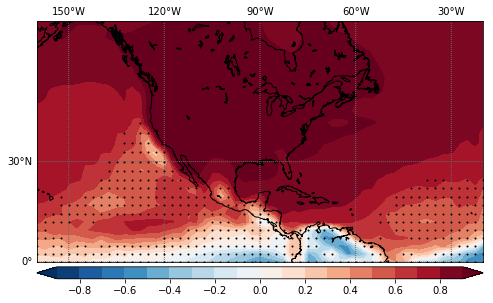

In [45]:
map = Basemap(projection='merc',llcrnrlat=0,urcrnrlat=60,llcrnrlon=200,urcrnrlon=340,lat_ts=20,resolution='l')
fig=plt.figure(figsize=(8,9))

map.fillcontinents(zorder=0)
map.drawcoastlines()
map.drawmeridians(np.arange(180,360,30),labels=[0,0,1,1],color='DimGray')
map.drawparallels(np.arange(-90,90,30),labels=[1,0,0,0],color='DimGray')

lons, lats = np.meshgrid(lon.values, lat.values)
x1,y1 = map(lons, lats)
clevs=np.linspace(-0.9,0.9,19)
cs=map.contourf(x1,y1,corr,clevs,cmap=plt.cm.RdBu_r,extend='both')
cbar = map.colorbar(cs,location='bottom')

x2,y2=map(lonex,latex)
passt=map.plot(x2,y2,'ko',markersize=1)
